In [1]:
import PIL.Image
import numpy as np
from typing import Union
from glob import glob
import pandas as pd
import os
#from treys import Card
from termcolor import colored
from utils import eval_listof_games , debug_listof_games, save_results , load_results
import scipy
from skimage.segmentation import flood, flood_fill
from skimage.morphology import closing, opening, disk

In [605]:
import skimage.io
import matplotlib.pyplot as plt
from skimage.segmentation import flood, flood_fill
from skimage import morphology
from skimage.morphology import closing, opening, disk, square, erosion
from skimage import filters
import cv2 as cv
from skimage.filters import threshold_multiotsu

In [432]:
from helper import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Note: histogram equalization really makes it easier

### Strategie


Use setup data to isolate numbers/letters and symbols and define the selection features (Fourier might be good, as there is only 1 way to write 1 symbol so quite deterministic, and invariability to rotation).

Proceed by "player space"

- cards
    - we must go for the numbers/letters and signs just under, as cards hidden behind others cannot be classified using the whole card.
    - once we have all the contours"
        - quick control of the possibility that a card is hidden (high fourier frequency ?) or a "dressed/ace" ? The come back with less frequencies ?
        - find the contours of interest by looking for which contour are the closest to target contours (experiment a bit with set up cards)?
    
- chips
    - Separate everything given the color (red, black, blue, green, white). 
    - get them when we get the rest

Import all train data

In [61]:
path_data = 'data/train'
i = 0
file = os.path.join(path_data, f"train_{str(i).zfill(2)}.jpg")
images = []

while os.path.exists(file):
    im = skimage.io.imread(file)
    images.append(im)
    i += 1
    file = os.path.join(path_data, f"train_{str(i).zfill(2)}.jpg")

Subsample to 2 images for now

In [25]:
images = [images[1], images[4], images[8], images[22]]

## Histogram equalization

In [26]:
equalized         = []
for image in images:
    equalized.append(hist_eq(image))

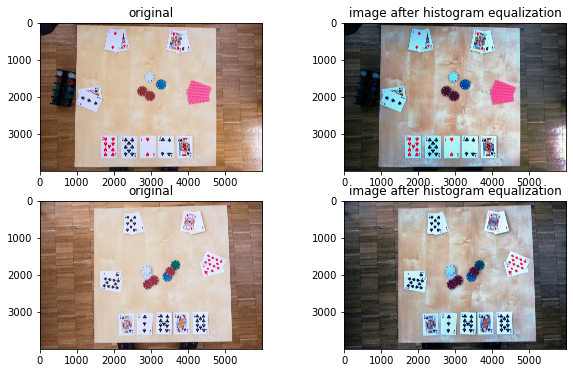

In [27]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(10,6))
for ax, image, edge in zip(axes, images, equalized):
    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('original')
    ax[1].imshow(edge, cmap=plt.cm.gray)
    ax[1].set_title('image after histogram equalization')
plt.show()

## Plot RGB channels

In [28]:
print(np.min([equalized[0]]), np.max(equalized[0]))

0.0009179709584131311 0.999931981348209


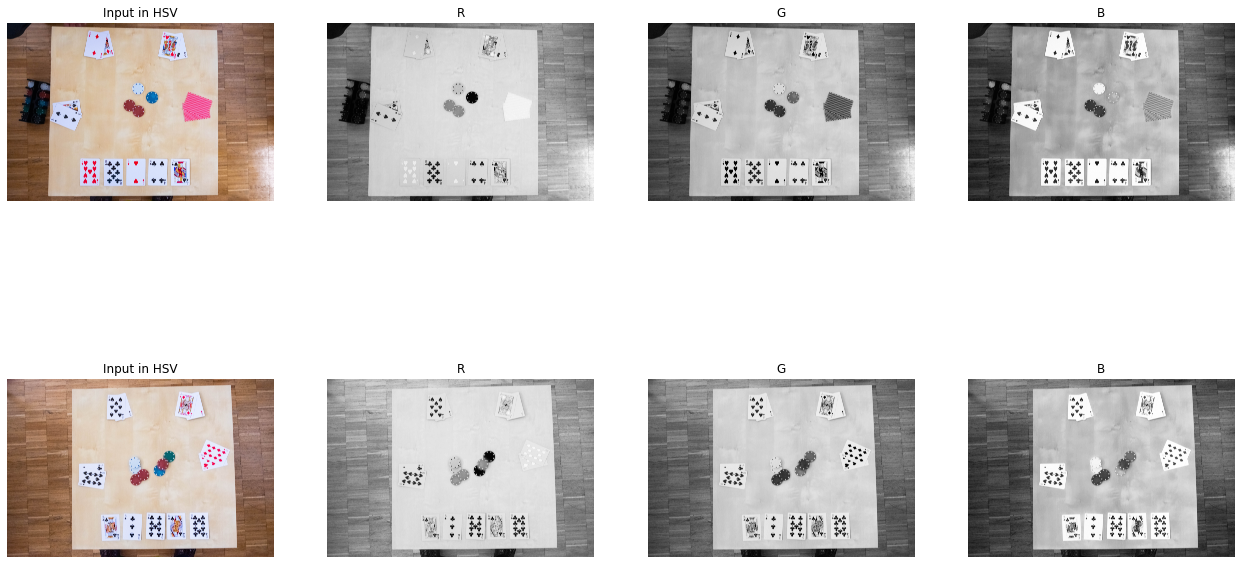

In [29]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(22, 12))

for i in range(2):
    ax[i,0].imshow(images[i])
    ax[i,0].set_title('Input in HSV')
    ax[i,0].axis('off')
    
    ax[i,1].imshow(images[i][:,:,0], cmap = 'gray')
    ax[i,1].set_title('R')
    ax[i,1].axis('off')
    
    ax[i,2].imshow(images[i][:,:,1], cmap = 'gray')
    ax[i,2].set_title('G')
    ax[i,2].axis('off')
    
    ax[i,3].imshow(images[i][:,:,2], cmap = 'gray')
    ax[i,3].set_title('B')
    ax[i,3].axis('off')
    ascii

## Plot hsv channels

In [30]:
equalized_hsv = [skimage.color.rgb2hsv(equalized[0]), skimage.color.rgb2hsv(equalized[1])]

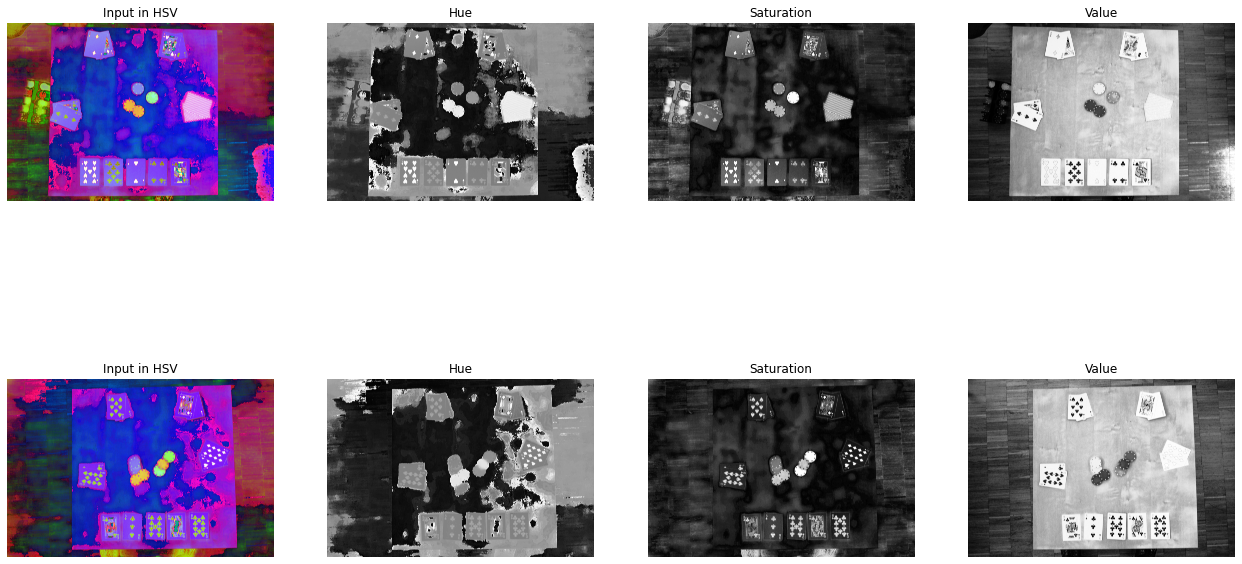

In [31]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(22, 12))

for i in range(2):
    ax[i,0].imshow(equalized_hsv[i])
    ax[i,0].set_title('Input in HSV')
    ax[i,0].axis('off')
    
    ax[i,1].imshow(equalized_hsv[i][:,:,0], cmap = 'gray')
    ax[i,1].set_title('Hue')
    ax[i,1].axis('off')
    
    ax[i,2].imshow(equalized_hsv[i][:,:,1], cmap = 'gray')
    ax[i,2].set_title('Saturation')
    ax[i,2].axis('off')
    
    ax[i,3].imshow(equalized_hsv[i][:,:,2], cmap = 'gray')
    ax[i,3].set_title('Value')
    ax[i,3].axis('off')
    ascii

## Isolation of table

In [32]:
binary = []
for eq in equalized:
    binary.append(binarization(eq))

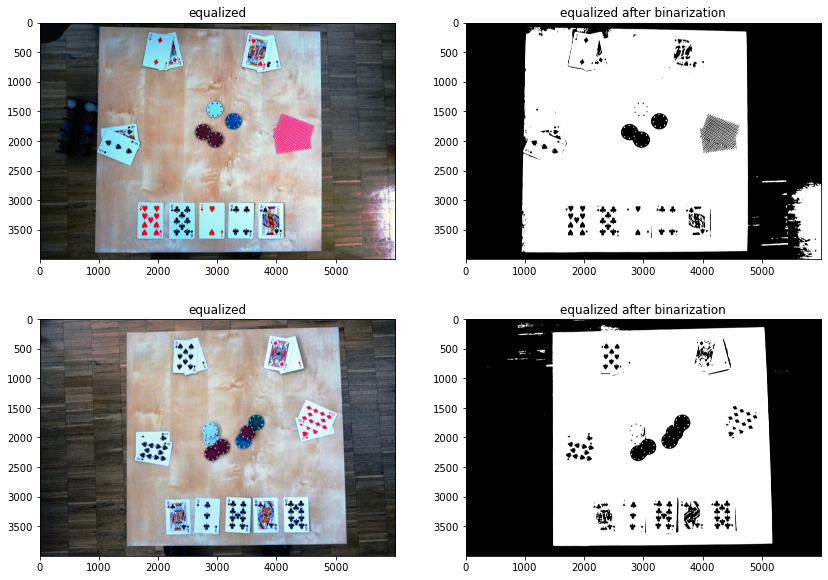

In [33]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(14,10))
for ax, image, map_ in zip(axes, equalized, binary):
    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('equalized')
    ax[1].imshow(map_, cmap=plt.cm.gray)
    ax[1].set_title('equalized after binarization')
plt.show()

In [34]:
masks, cropped_img = [], []
for image, bin_img in zip(images, binary):
    mask, crop = crop_table_from_binary(image, bin_img)
    masks.append(mask)
    cropped_img.append(crop)

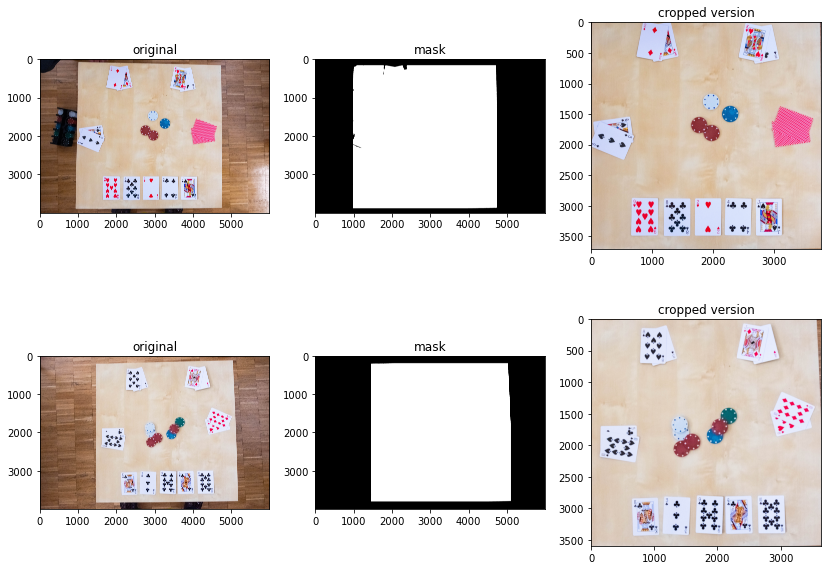

In [35]:
fig, axes = plt.subplots(ncols = 3, nrows = 2, figsize=(14,10))
for ax, image, mask, crop in zip(axes, images, masks, cropped_img):
    ax[0].imshow(image)
    ax[0].set_title('original')
    ax[1].imshow(mask, cmap=plt.cm.gray)
    ax[1].set_title('mask')
    ax[2].imshow(crop)
    ax[2].set_title('cropped version')
plt.show()

## General function **cropping_routine()** which gives directly the crop from original:

In [62]:
cropped_img = []
for image in images:
    _, crop = cropping_routine(image)
    cropped_img.append(crop)

We equalized histograms to isolate the table more easily, but we treat the table we do not want to have a high contrast within the table structure, so we crop the original? (maybe not wise for color segmentation for chips)

## Table areas definition

In [37]:
path_data = 'data/image_setup/'

backs = path_data + 'back_cards.jpg'
paths = [backs]

[backs] = load_data(paths)

In [38]:
_, crop = cropping_routine(backs)

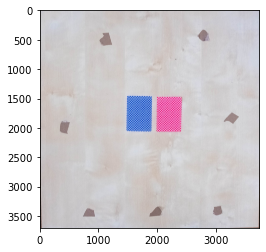

In [39]:
plt.imshow(crop)
plt.show()

### Find origin of markers

In [40]:
idx = [1750,350,400,1900,3350,3350,3320]
row = 200
idy = [3170,2700,1050,300,750,1900,2930]
col = 200

scotch, center_point = [], []
for x,y in zip(idx, idy):
    loc = crop[x:x+row, y:y+col]
    ct = np.array([(x+x+row)//2, (y+y+col)//2])
    scotch.append(loc)
    center_point.append(ct)
    
# isolate cards
idx = 1455
row = 610
idy = 1465
col = 440
card = crop[idx:idx+row, idy:idy+col]
scotch.append(card)
#center_point.append(np.array([(idy+idy+col)//2, (idx+idx+row)//2]))
center_point = np.asarray(center_point, dtype = 'object')

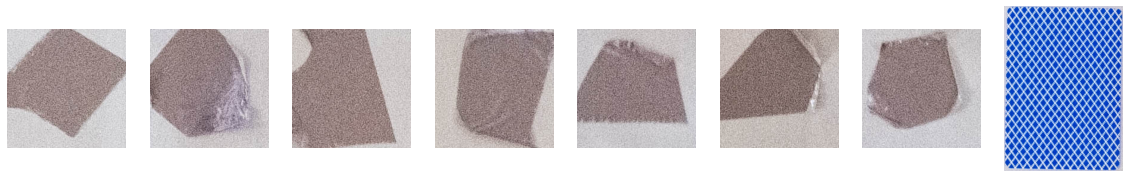

In [41]:
fig, axes = plt.subplots(ncols=8, figsize=(20,6))
for ax, img in zip(axes.flatten(), scotch):
    ax.imshow(img)
    ax.axis('off')
plt.show()

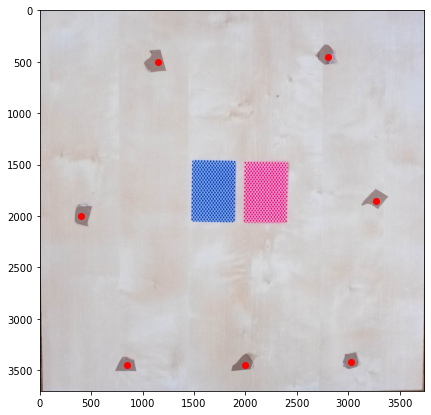

In [42]:
plt.figure(figsize=(10,7))
plt.imshow(crop)
plt.scatter(center_point[:,1], center_point[:,0], color = 'red')
plt.show()

In [43]:
print(f'Rows of table: {crop.shape[0]}')
print(f'Cols of table: {crop.shape[1]}')
# for i, ct in enumerate(center_point[:4]):
#     print(f'Player {i+1} at: {ct}')
# for i, ct in enumerate(center_point[4:]):
#     print(f'Common card {2*i+1} at: {ct}')
print(f'Card dimension: {card.shape[:2]}')

Rows of table: 3701
Cols of table: 3738
Card dimension: (610, 440)


Define the origin of markers and expected card size by a ratio with the table shape (which is supposed to be always the same)

In [44]:
cards_markers = []
for i, ct in enumerate(center_point[:4]):
    print(f'Player {i+1} at {round(ct[0] / crop.shape[0], 3)} % of table rows, {round(ct[1] / crop.shape[1], 3)} % of table cols')
for i, ct in enumerate(center_point[4:]):
    print(f'Common card {2*i+1} at: {round(ct[0] / crop.shape[0], 3)} % of table rows, {round(ct[1] / crop.shape[1], 3)} % of table cols')
print(f'Card dimension: {round(card.shape[0] / crop.shape[0], 3)} % of table rows, {round(card.shape[1] / crop.shape[1], 3)} % of table cols')

Player 1 at 0.5 % of table rows, 0.875 % of table cols
Player 2 at 0.122 % of table rows, 0.749 % of table cols
Player 3 at 0.135 % of table rows, 0.308 % of table cols
Player 4 at 0.54 % of table rows, 0.107 % of table cols
Common card 1 at: 0.932 % of table rows, 0.227 % of table cols
Common card 3 at: 0.932 % of table rows, 0.535 % of table cols
Common card 5 at: 0.924 % of table rows, 0.811 % of table cols
Card dimension: 0.165 % of table rows, 0.118 % of table cols


## Define global markers and use them to find search areas

In [45]:
""" GLOBAL CONSTANTS (SCOTCH MARKERS) """
P1 = [0.5, 0.875]
P2 = [0.122, 0.749]
P3 = [0.135, 0.308]
P4 = [0.54, 0.107]
C1 = [0.932, 0.227]
C2 = [0.932, 0.381]
C3 = [0.932, 0.535]
C4 = [0.932, 0.673]
C5 = [0.924, 0.811]
MARKERS = np.array([P1, P2, P3, P4,
                          C1, C2, C3, C4, C5])
CARD_DIM = [0.165, 0.118]

""" Use global constants in functions """

def find_markers_idx(image):
    table_dim = image.shape[:2]
    return (MARKERS * table_dim).astype(int)

def find_player_search_area(image, marker):
    # adapt search area to table size
    row, col = image.shape[:2]
    R, C = int(row/6), int(col/6)
    x1, x2, y1, y2 = marker[0]-R, marker[0]+R, marker[1]-C, marker[1]+C
    # return a crop on the image
    x1, x2 = np.clip([x1, x2], 0, row)
    y1, y2 = np.clip([y1, y2], 0, col)
    search_area = image[x1:x2, y1:y2]
    return search_area

# def find_common_search_area(image, marker):
#     """TO REFINE"""
#     # adapt card size to table size
#     row, col = image.shape[:2]
#     R, C = int((CARD_DIM[0]*row)/2), int((CARD_DIM[1]*col)/2)
#     x1, x2, y1, y2 = marker[0]-R, marker[0]+R, marker[1]-C, marker[1]+C
#     # return a crop on the image
#     x1, x2 = np.clip([x1, x2], 0, row)
#     y1, y2 = np.clip([y1, y2], 0, col)
#     search_area = image[x1:x2, y1:y2]
#     return search_area

def find_common_search_area(image, markers):
    """ Works but a bit edgy, would be better to rely on something else """
    # isolate a 1rst big search area in bottom 3rd of the image
    row, col = image.shape[:2]
    C = int((CARD_DIM[1]*col))
    start, end = markers[0,1]-C, markers[-1,1]+C
    big_area = image[int(2/3*row):row, start:end]
    
    # refine using edge detector and contours filtering
    edges = edge_detector([big_area])[0]
    contours = contours_by_img([edges])[0]
    contours = filter_contours_by_size([contours], 100, 3000)[0]
    start = np.min([np.min(contour[0,:]) for contour in contours])
    end = np.max([np.max(contour[0,:]) for contour in contours])

    # rescale image and divide in 5
    big_area = big_area[:,start:end]
    w = int(big_area.shape[1]/5)
    cards = [big_area[ : , w*i : w*(1+i) ] for i in range(5)]
    return cards

def find_chips_search_area(image):
    # adapt search area to table size
    row, col = image.shape[:2]
    R, C = int(row/4), int(col/4)
    R_2 = 3*R
    C_2 = 3*C
    # return a crop on the image
    search_area = image[R:R_2, C:C_2]
    return search_area

Player search

In [46]:
idx = 0

In [47]:
markers = find_markers_idx(cropped_img[idx])
player_markers, common_markers = markers[:4], markers[4:]
player_areas = []
for marker in player_markers:
    search_area = find_player_search_area(cropped_img[idx], marker)
    player_areas.append(search_area)

Common search

In [48]:
markers = find_markers_idx(cropped_img[idx])
player_markers, common_markers = markers[:4], markers[4:]
# common_areas = []
# for marker in common_markers:
#     search_area = find_common_search_area(cropped_img[idx], marker)
#     common_areas.append(search_area)
common_areas = find_common_search_area(cropped_img[idx], common_markers)

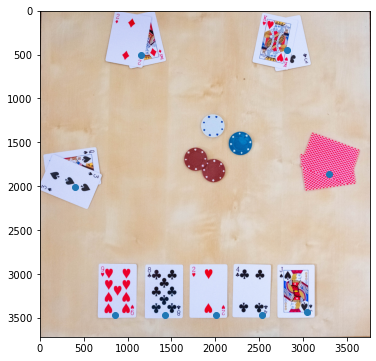

In [49]:
plt.figure(figsize=(6,6))
plt.scatter(markers[:,1], markers[:,0])
plt.imshow(cropped_img[idx])
plt.show()

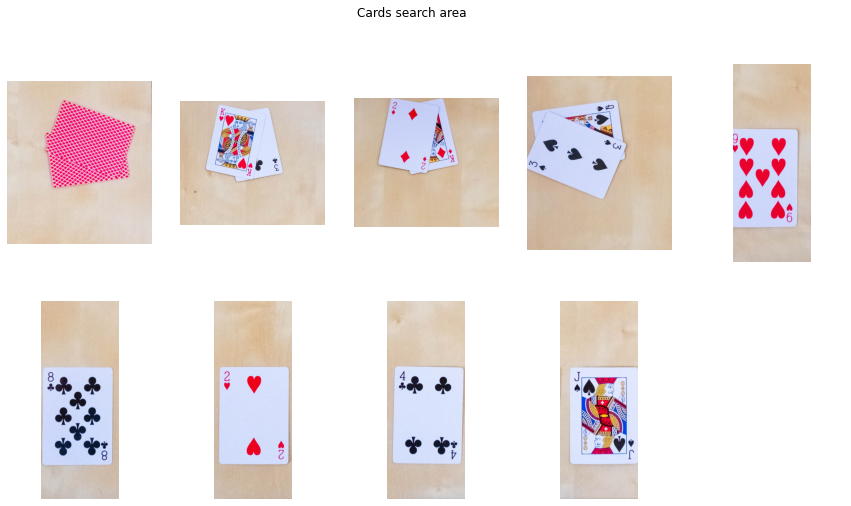

In [50]:
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize=(15,8))
for area, ax in zip(player_areas + common_areas, axes.flatten()):
    ax.imshow(area)
    ax.axis('off')
axes[-1,-1].axis('off')
fig.suptitle('Cards search area')
plt.show()

# Chips

In [578]:
path_data = 'data/train'
i = 0
file = os.path.join(path_data, f"train_{str(i).zfill(2)}.jpg")
images = []

while os.path.exists(file):
    im = skimage.io.imread(file)
    images.append(im)
    i += 1
    file = os.path.join(path_data, f"train_{str(i).zfill(2)}.jpg")
    
cropped_img = []
for image in images:
    _, crop = cropping_routine(image)
    cropped_img.append(crop)

In [579]:
idx = 12
chips_area = find_chips_search_area(cropped_img[idx])

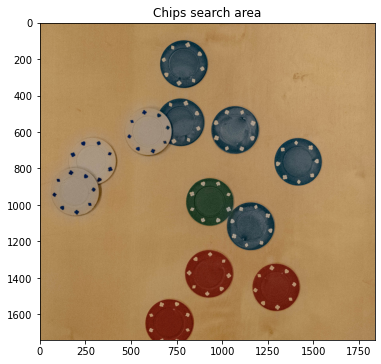

In [580]:
plt.figure(figsize=(6,6))
plt.imshow(chips_area)
plt.title('Chips search area')
plt.show()

In [83]:
predict_white(chips_area)

2

In [95]:
predict_blue(chips_area)

0

In [296]:
predict_green(chips_area)

3

In [298]:
predict_green(chips_area)

2

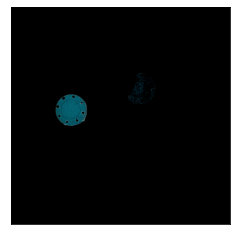

KeyboardInterrupt: 

In [424]:
for im in cropped_img:
    
    chips_area = find_chips_search_area(im)
    
    lower = np.array([25, 52, 70])
    upper = np.array([99, 255, 255]) 


    mask  = np.zeros((1, 1, 1))

    img_hsv = cv.cvtColor(chips_area, cv.COLOR_RGB2HSV)

    full_mask = cv.inRange(img_hsv, lower, upper)

    mask = cv.bitwise_and(chips_area,chips_area, mask = full_mask)

    display_image(mask)
    plt.show()
    
    bins = skimage.color.rgb2gray(mask)
    bins[bins>10] = 1
    bins[bins!=1] = 0
    clos = closing(bins,disk(20))
    op = opening(clos,disk(20))
    
    display_image(op)
    plt.show()

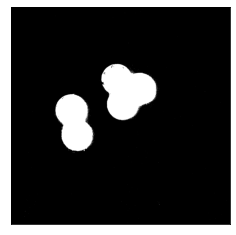

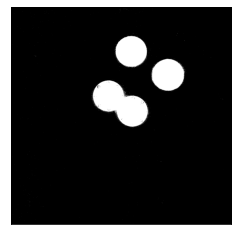

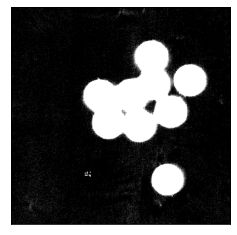

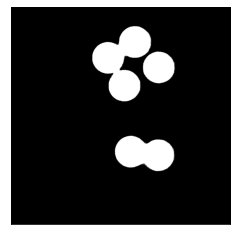

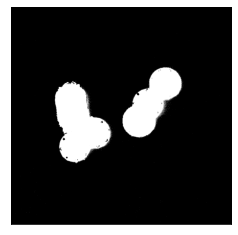

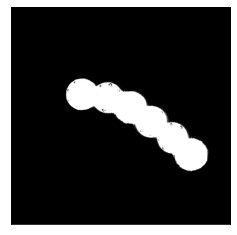

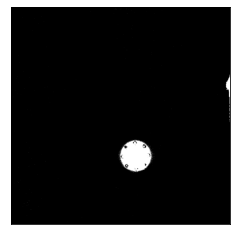

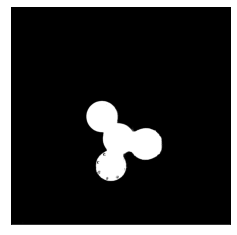

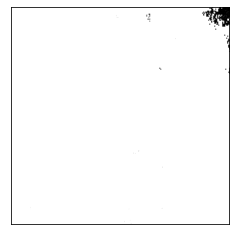

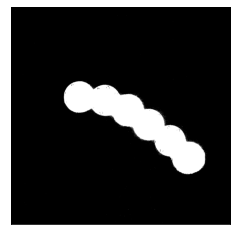

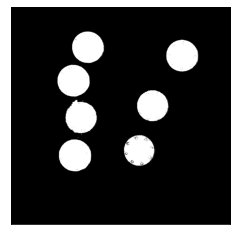

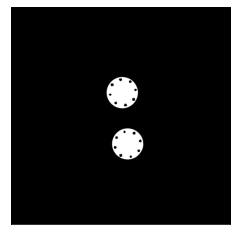

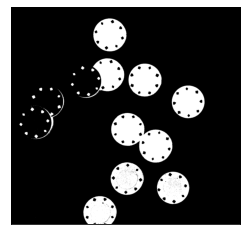

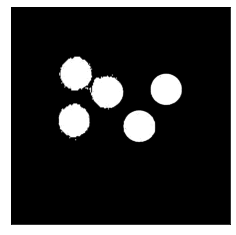

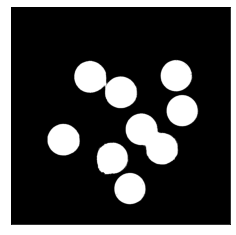

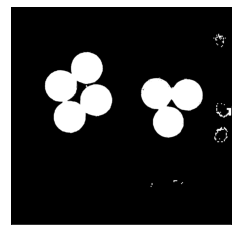

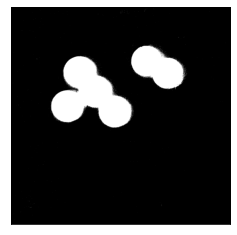

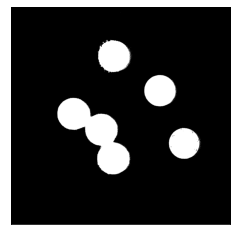

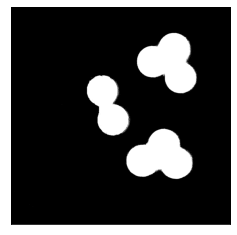

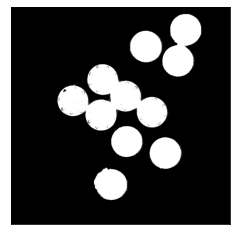

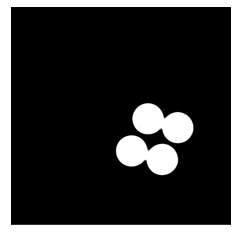

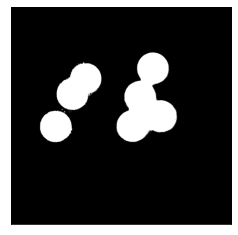

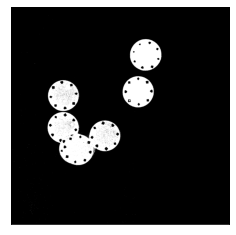

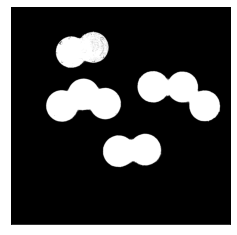

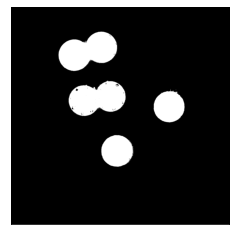

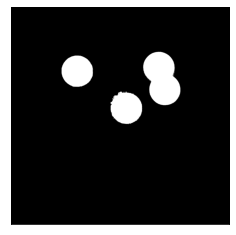

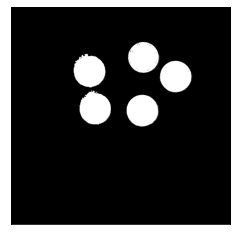

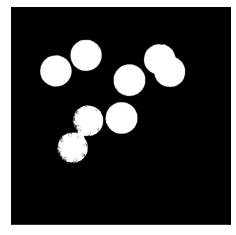

In [263]:
numeri = []
for im in cropped_img:
    chips_area = find_chips_search_area(im)
    numeri.append(predict_nb(chips_area))

In [ ]:
lower = np.array([25, 52, 72])
upper = np.array([102, 255, 255]) 

In [361]:
idx = 22
chips_area = find_chips_search_area(cropped_img[idx])
np.mean(chips_area[0:10,0:10][0])
np.mean(chips_area[0:10,0:10][1])

119.8

In [358]:
idx = 10
chips_area = find_chips_search_area(cropped_img[idx])
chips_area[0,0]

array([246, 234, 218], dtype=uint8)

In [ ]:
lower = np.array([25, 52, 72])
upper = np.array([99, 255, 255]) 

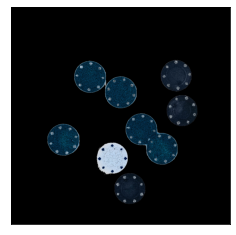

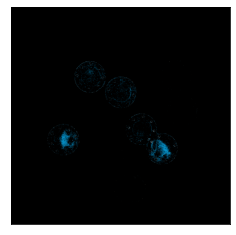

In [393]:
idx = 14
chips_area = find_chips_search_area(cropped_img[idx])

lower = np.array([90, 0, 0])
upper = np.array([180, 250, 250]) 

mask  = np.zeros((1, 1, 1))

img_hsv = cv.cvtColor(chips_area, cv.COLOR_RGB2HSV)


full_mask = cv.inRange(img_hsv, lower, upper)

mask = cv.bitwise_and(chips_area,chips_area, mask = full_mask)

display_image(mask)
plt.show()


lower = np.array([25, 0, 0])
upper = np.array([180, 250, 250]) 

lower = np.array([25, 52, 0])
upper = np.array([99, 255, 255]) 

nb_pix  = 0 
mask  = np.zeros((1, 1, 1))

img_hsv = cv.cvtColor(chips_area, cv.COLOR_RGB2HSV)


full_mask = cv.inRange(img_hsv, lower, upper)

mask = cv.bitwise_and(chips_area,chips_area, mask = full_mask)

display_image(mask)
plt.show()

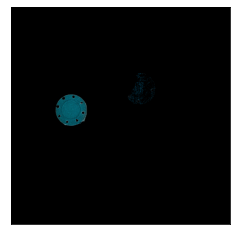

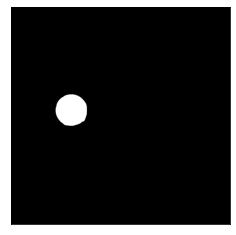

7

In [292]:
green = np.array([168, 86, 62])


lower = np.array([25, 52, 72])
upper = np.array([99, 255, 255]) 


nb_pix  = 0 
mask  = np.zeros((1, 1, 1))

img_hsv = cv.cvtColor(chips_area, cv.COLOR_RGB2HSV)


full_mask = cv.inRange(img_hsv, lower, upper)

mask = cv.bitwise_and(chips_area,chips_area, mask = full_mask)

display_image(mask)
plt.show()

bins = binarization(mask)
clos = closing(bins,disk(20))
op = opening(clos,disk(20))
display_image(op)
plt.show()
    
nb_pix = np.sum(op==1)


x = chips_area.shape[0]
y = chips_area.shape[1]
n = np.ceil(nb_px/(x*y)/CHIPS_AREA)

int(n)


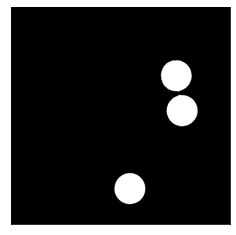

In [407]:
lower = np.array([0,0,0])
upper = np.array([180,255,60])
mask_black,_ = mask_c(chips_area, lower, upper)
display_image(mask_black)
plt.show()

In [494]:
def mask_new(chips_area, lower, upper):
    mask  = np.zeros((1, 1, 1))

    img_hsv = cv.cvtColor(chips_area, cv.COLOR_RGB2HSV)


    full_mask = cv.inRange(img_hsv, lower, upper)

    clos = closing(full_mask,disk(20))
    op = opening(clos,disk(20))
    
    
    op[op<=127]=0
    op[op>127]=1
    
    return op

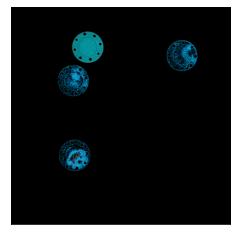

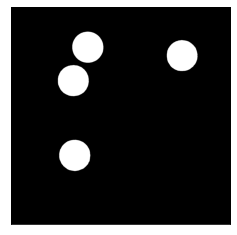

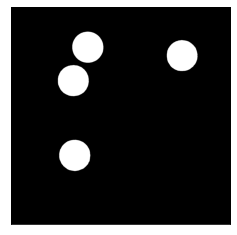

In [441]:
idx = 10
chips_area = find_chips_search_area(cropped_img[idx])

lower = np.array([25, 52, 72]) 
upper = np.array([99, 255, 255]) 

mask  = np.zeros((1, 1, 1))

img_hsv = cv.cvtColor(chips_area, cv.COLOR_RGB2HSV)


full_mask = cv.inRange(img_hsv, lower, upper)

mask = cv.bitwise_and(chips_area,chips_area, mask = full_mask)

display_image(mask)
plt.show()

clos = closing(full_mask,disk(20))
op = opening(clos,disk(20))
display_image(op)
plt.show()

display_image(mask_new(chips_area, lower, upper))
plt.show()

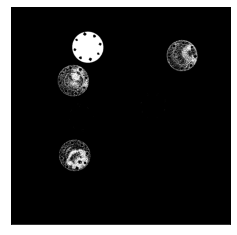

In [436]:
display_image(full_mask)

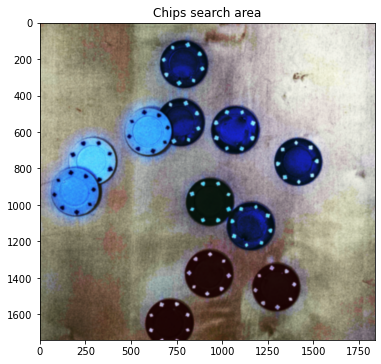

In [596]:
idx = 12
chips_area = find_chips_search_area(cropped_img[idx])
chip_area = np.uint8(hist_eq(chips_area)*255)
#chips_area = cv.cvtColor(img_hsv, cv.COLOR_HSV2RGB)
plt.figure(figsize=(6,6))
plt.imshow(chip_area)
plt.title('Chips search area')
plt.show()

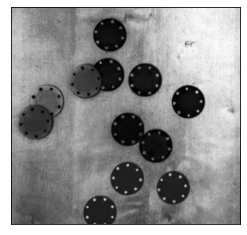

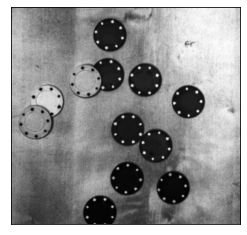

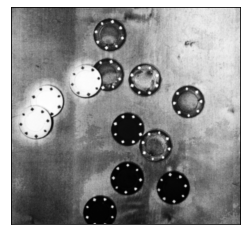

In [593]:
display_image(chip_area[:,:,0])
plt.show()
display_image(chip_area[:,:,1])
plt.show()
display_image(chip_area[:,:,2])
plt.show()

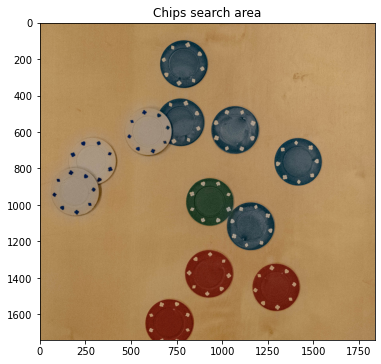

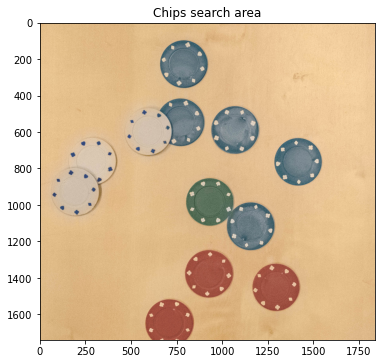

In [598]:
idx = 12
chips_area = find_chips_search_area(cropped_img[idx])

plt.figure(figsize=(6,6))
plt.imshow(chips_area)
plt.title('Chips search area')
plt.show()

ref = 10
chips_ref = find_chips_search_area(cropped_img[ref])


md=0
img_hsv = cv.cvtColor(chips_area, cv.COLOR_RGB2HSV)
for k in [0,1,2]:
    md=md+np.mean(chips_area[0:10, 0:10,k])-np.mean(chips_ref[0:10, 0:10,k])
    
md=md/6
chips_area2=np.int64(chips_area)-md
chips_area2[chips_area2>255]=255
chips_area2[chips_area2<0]=0

chips_area2=np.uint8(chips_area2)
    
plt.figure(figsize=(6,6))
plt.imshow(chips_area2)
plt.title('Chips search area')
plt.show()

1

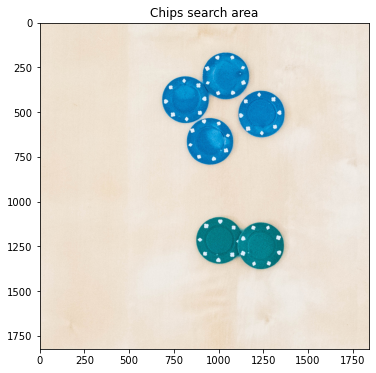

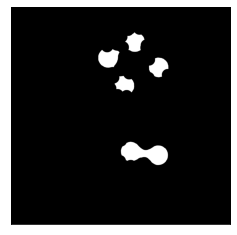

In [611]:
idx = 3
chips_area = find_chips_search_area(cropped_img[idx])


plt.figure(figsize=(6,6))
plt.imshow(chips_area)
plt.title('Chips search area')
plt.show()

chip = predict_chips_area(chips_area)

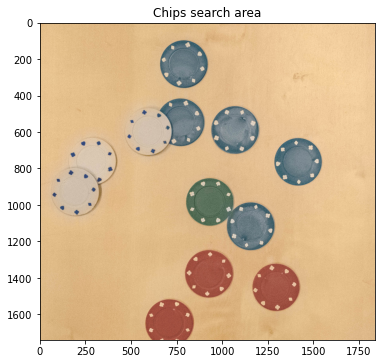

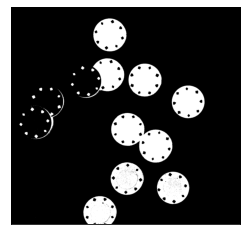

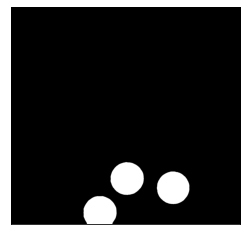

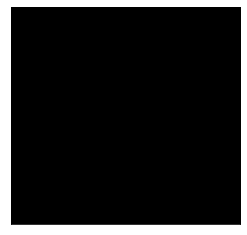

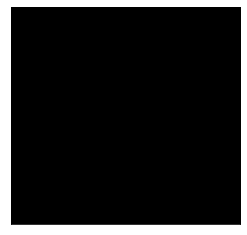

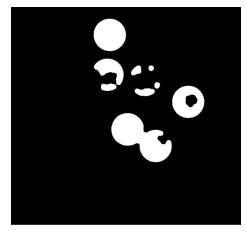

In [599]:
idx = 12
chips_area = find_chips_search_area(cropped_img[idx])

chips_area = chips_area2

plt.figure(figsize=(6,6))
plt.imshow(chips_area)
plt.title('Chips search area')
plt.show()

chip = predict_chips_area(chips_area)

n_red, mask_red = pred_red(chips_area)
display_image(mask_red)
plt.show()

lower = np.array([0,0,0])
upper = np.array([180,255,60])
mask_black= mask_new(chips_area,lower,upper)
display_image(mask_black)
plt.show()

lower = np.array([100,150,0])
upper = np.array([140,255,255])
    
mask_blue= mask_new(chips_area, lower , upper)
display_image(mask_blue)
plt.show()

lower = np.array([25, 52, 72]) 
upper = np.array([99, 255, 255]) 

mask_green= mask_new(chips_area, lower , upper)
display_image(mask_green)
plt.show()

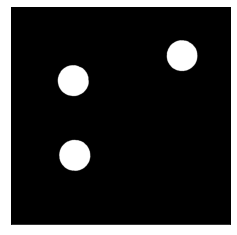

In [454]:
display_image(mask_blue)
plt.show()

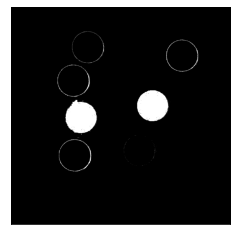

In [502]:
display_image(chip)
plt.show()

In [507]:
schip=np.copy(chip)
mask_green_s=np.copy(mask_green)
mask_black_s=np.copy(mask_black)
mask_blue_s=np.copy(mask_blue)


In [508]:
chip=np.copy(schip)
mask_green=np.copy(mask_green_s)
mask_black=np.copy(mask_black_s)
mask_blue=np.copy(mask_blue_s)

In [600]:
chip[mask_red == 1] = 0
mask_black[mask_black * chip == 0] = 0
chip[mask_black == 1] = 0
mask_blue[mask_blue * chip == 0] = 0
chip[mask_blue == 1] = 0
mask_green[mask_green * chip == 0] = 0
chip[mask_green == 1] = 0
     
     
mask_black = opening(mask_black,disk(20))
mask_blue = opening(mask_blue,disk(20))     
mask_green = opening(mask_green,disk(20))
mask_white = opening(chip,disk(20))
     

x = chips_area.shape[0]
y = chips_area.shape[1]
    
print(np.ceil(n_red/(x*y)/CHIPS_AREA))
print(np.ceil(np.sum(mask_black)/(x*y)/CHIPS_AREA))
print(np.ceil(np.sum(mask_blue)/(x*y)/CHIPS_AREA))
print(np.ceil(np.sum(mask_green)/(x*y)/CHIPS_AREA))
print(np.ceil(np.sum(mask_white)/(x*y)/CHIPS_AREA))
     


1.0
0.0
0.0
4.0
2.0


In [483]:
chip=np.copy(schip)
mask_green=np.copy(mask_green_s)
mask_black=np.copy(mask_black_s)
mask_blue=np.copy(mask_blue_s)

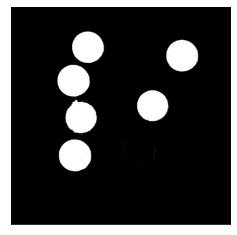

In [488]:
chip[mask_blue == 1 ] = 0
display_image(chip)
plt.show()

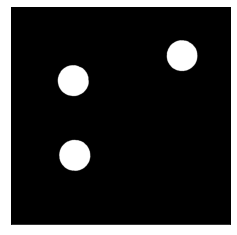

In [487]:
mask_blue[mask_blue * chip] = 0
display_image(mask_blue)
plt.show()

In [496]:
mask_blue.shape

(1810, 1824)

In [471]:
chip

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

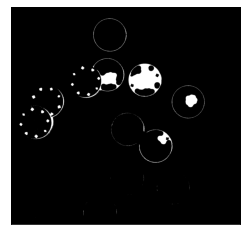

In [601]:
#chip[mask_bllue == chip] = 0
display_image(chip)
plt.show()

In [397]:
def pred_red(chips_area):
    mask,nb_px = red_mask(chips_area)
    
    x = chips_area.shape[0]
    y = chips_area.shape[1]
    
    n = np.ceil(nb_px/(x*y)/CHIPS_AREA)
    
    return int(n), mask


In [851]:
def predict_chips_area(chips_area):
    
    chips_area_hsv = cv.cvtColor(chips_area, cv.COLOR_RGB2HSV)
    thresholds = threshold_multiotsu(chips_area_hsv[:,:,2], classes = 2)

    # Using the threshold values, we generate the three regions.
    regions = np.digitize(chips_area_hsv[:,:,2], bins=thresholds)

    thresholds1 = threshold_multiotsu(chips_area_hsv[:,:,0], classes = 2)

    # Using the threshold values, we generate the three regions.
    regions1 = np.digitize(chips_area_hsv[:,:,0], bins=thresholds1)

    tot = (1-regions) + regions1

    tot[tot>0.5] = 1
    #tot = closing(tot,disk(20))
    #display_image(tot)
    #plt.show()
    #tot = erosion(tot,disk(30))
    #display_image(tot)
    #plt.show()
    
    #return tot
    
    nb_px = np.sum(tot == 1)
    
    x = chips_area.shape[0]
    y = chips_area.shape[1]
    
    
    x = nb_px/(x*y)/CHIPS_AREA
    
    return round_(x,T=0.2),tot
    

In [771]:
def round_(x,T):
    
    n = np.floor(x)
    if (x-n > T): n += 1
    
    return int(n)
    
def n_chips(N,chips_area):
    x = chips_area.shape[0]
    y = chips_area.shape[1]
    
    
    x = N/(x*y)/CHIPS_AREA
    
    return round_(x,T=0.3)

In [859]:
l

[2,
 2,
 8,
 4,
 1,
 2,
 0,
 1,
 0,
 2,
 3,
 0,
 4,
 1,
 5,
 1,
 4,
 3,
 3,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 2]

In [858]:
idx = 13
l = []
for im in cropped_img:
    chips_area = find_chips_search_area(im)


    #plt.figure(figsize=(6,6))
    #plt.imshow(chips_area)
    #plt.title('Chips search area')
    #plt.show()

    pred,final_mask = predict_chips_area(chips_area)

    #print(pred)

    color = give_color(chips_area,final_mask)
    #print(n_chips(np.sum(color==1),final_mask))
    l.append(n_chips(np.sum(color==4),final_mask))
    

In [857]:
def give_color(chips_area,final_mask):
    
    chips_area_hsv = cv.cvtColor(chips_area, cv.COLOR_RGB2HSV)
    result = np.zeros(chips_area_hsv[:,:,0].shape)
    
    
    chips_area_hsv = np.float64(chips_area_hsv)
    
    x = np.mean(chips_area[0:10,0:10,2])
    black = int(72/(luce-noluce) * (x-noluce) + 38)
    #print(black)
    #black = 84
    result[chips_area_hsv[:,:,2] < black] = 1 #black
    chips_area_hsv[result!=0,:] = float("NAN")
    
    result[chips_area_hsv[:,:,1] < 50] = 2 #white
    chips_area_hsv[result!=0,:] = float("NAN")
    
    result[(chips_area_hsv[:,:,0] < 10) + (chips_area_hsv[:,:,0] >160)] = 3 #red
    chips_area_hsv[result!=0,:] = float("NAN")
    
    result[(chips_area_hsv[:,:,0] > 95) * (chips_area_hsv[:,:,0] < 140)] = 4 #blue
    chips_area_hsv[result!=0,:] = float("NAN")
    
    result[(chips_area_hsv[:,:,0] > 40) * (chips_area_hsv[:,:,0] < 95)] = 5 #green
    
    result = result*final_mask
    
    return result

In [752]:
color = give_color(chips_area,final_mask)
n_chips(np.sum(color==1),final_mask)

0

In [831]:
idx=10
chips_area = find_chips_search_area(cropped_img[idx])
luce = np.mean(chips_area[0:10,0:10,2])
luce

221.26

In [830]:
idx=12
chips_area = find_chips_search_area(cropped_img[idx])
noluce = np.mean(chips_area[0:10,0:10,2])
noluce

86.66

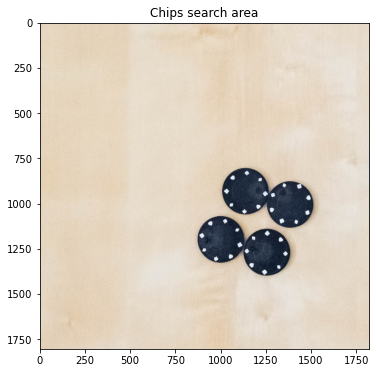

4


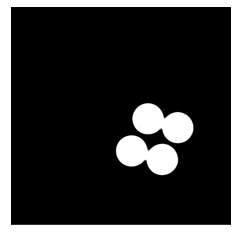

In [850]:
idx=20
chips_area = find_chips_search_area(cropped_img[idx])


plt.figure(figsize=(6,6))
plt.imshow(chips_area)
plt.title('Chips search area')
plt.show()

pred,final_mask = predict_chips_area(chips_area)

#print(pred)

color = give_color(chips_area,final_mask)
print(n_chips(np.sum(color==1),final_mask))

In [243]:
CHIPS_AREA = 50000/(1750*1760)

In [386]:
game_results1 = {}

for i,im in enumerate(cropped_img):
    chips_area = find_chips_search_area(im)
    dct = {}
    dct["CR"] = predict_red(chips_area)
    dct["CG"] = predict_green(chips_area)
    dct["CB"] = predict_blue(chips_area)
    dct["CK"] = predict_black(chips_area)
    dct["CW"] = predict_white(chips_area)
    
    game_results1[i] = dct

In [387]:
game_results1

{0: {'CR': 1, 'CG': 2, 'CB': 1, 'CK': 1, 'CW': 1},
 1: {'CR': 2, 'CG': 0, 'CB': 1, 'CK': 0, 'CW': 1},
 2: {'CR': 0, 'CG': 0, 'CB': 8, 'CK': 1, 'CW': 0},
 3: {'CR': 0, 'CG': 3, 'CB': 4, 'CK': 0, 'CW': 51},
 4: {'CR': 3, 'CG': 1, 'CB': 1, 'CK': 0, 'CW': 2},
 5: {'CR': 2, 'CG': 1, 'CB': 2, 'CK': 1, 'CW': 53},
 6: {'CR': 1, 'CG': 0, 'CB': 0, 'CK': 0, 'CW': 45},
 7: {'CR': 1, 'CG': 0, 'CB': 1, 'CK': 2, 'CW': 0},
 8: {'CR': 0, 'CG': 0, 'CB': 0, 'CK': 0, 'CW': 0},
 9: {'CR': 2, 'CG': 1, 'CB': 2, 'CK': 1, 'CW': 0},
 10: {'CR': 1, 'CG': 1, 'CB': 3, 'CK': 0, 'CW': 56},
 11: {'CR': 0, 'CG': 1, 'CB': 0, 'CK': 2, 'CW': 0},
 12: {'CR': 4, 'CG': 5, 'CB': 0, 'CK': 3, 'CW': 0},
 13: {'CR': 0, 'CG': 1, 'CB': 1, 'CK': 0, 'CW': 54},
 14: {'CR': 0, 'CG': 1, 'CB': 5, 'CK': 3, 'CW': 1},
 15: {'CR': 3, 'CG': 0, 'CB': 2, 'CK': 2, 'CW': 40},
 16: {'CR': 0, 'CG': 0, 'CB': 4, 'CK': 0, 'CW': 2},
 17: {'CR': 1, 'CG': 0, 'CB': 3, 'CK': 1, 'CW': 1},
 18: {'CR': 0, 'CG': 3, 'CB': 3, 'CK': 1, 'CW': 2},
 19: {'CR': 5, '

In [334]:
game_results

{0: {'CR': 1, 'CG': 1, 'CB': 1, 'CK': 1, 'CW': 1},
 1: {'CR': 2, 'CG': 0, 'CB': 1, 'CK': 0, 'CW': 1},
 2: {'CR': 0, 'CG': 0, 'CB': 8, 'CK': 1, 'CW': 0},
 3: {'CR': 0, 'CG': 2, 'CB': 4, 'CK': 0, 'CW': 50},
 4: {'CR': 3, 'CG': 1, 'CB': 1, 'CK': 0, 'CW': 1},
 5: {'CR': 2, 'CG': 1, 'CB': 2, 'CK': 1, 'CW': 53},
 6: {'CR': 1, 'CG': 0, 'CB': 0, 'CK': 0, 'CW': 45},
 7: {'CR': 1, 'CG': 0, 'CB': 1, 'CK': 2, 'CW': 0},
 8: {'CR': 0, 'CG': 0, 'CB': 0, 'CK': 0, 'CW': 0},
 9: {'CR': 2, 'CG': 1, 'CB': 2, 'CK': 1, 'CW': 0},
 10: {'CR': 1, 'CG': 1, 'CB': 3, 'CK': 0, 'CW': 56},
 11: {'CR': 0, 'CG': 0, 'CB': 0, 'CK': 2, 'CW': 0},
 12: {'CR': 3, 'CG': 3, 'CB': 0, 'CK': 2, 'CW': 0},
 13: {'CR': 0, 'CG': 1, 'CB': 1, 'CK': 0, 'CW': 54},
 14: {'CR': 0, 'CG': 0, 'CB': 5, 'CK': 3, 'CW': 1},
 15: {'CR': 3, 'CG': 0, 'CB': 3, 'CK': 2, 'CW': 39},
 16: {'CR': 0, 'CG': 0, 'CB': 4, 'CK': 0, 'CW': 2},
 17: {'CR': 1, 'CG': 0, 'CB': 3, 'CK': 1, 'CW': 1},
 18: {'CR': 0, 'CG': 3, 'CB': 3, 'CK': 0, 'CW': 1},
 19: {'CR': 5, '

wrong 3,5,6,10,12,13,15,20,21,22,27

after ceiling 4, 18 are correct

after black -> predict blue 24,25

## Final segmentation routine

In [31]:
""" GLOBAL CONSTANTS (SCOTCH MARKERS) """
P1 = [0.5, 0.875]
P2 = [0.122, 0.749]
P3 = [0.135, 0.308]
P4 = [0.54, 0.107]
C1 = [0.932, 0.227]
C2 = [0.932, 0.381]
C3 = [0.932, 0.535]
C4 = [0.932, 0.673]
C5 = [0.924, 0.811]
MARKERS = np.array([P1, P2, P3, P4,
                          C1, C2, C3, C4, C5])
CARD_DIM = [0.165, 0.118]

In [32]:
test_image = images[2]

crop table and define markers on it

In [33]:
_, crop = cropping_routine(test_image)
markers = find_markers_idx(crop)
player_markers, common_markers = markers[:4], markers[4:]

isolate player areas

In [34]:
player_areas = []
for marker in player_markers:
    search_area = find_player_search_area(crop, marker)
    player_areas.append(search_area)

isolate common cards areas

In [35]:
common_areas = find_common_search_area(crop, common_markers)

(verify result)

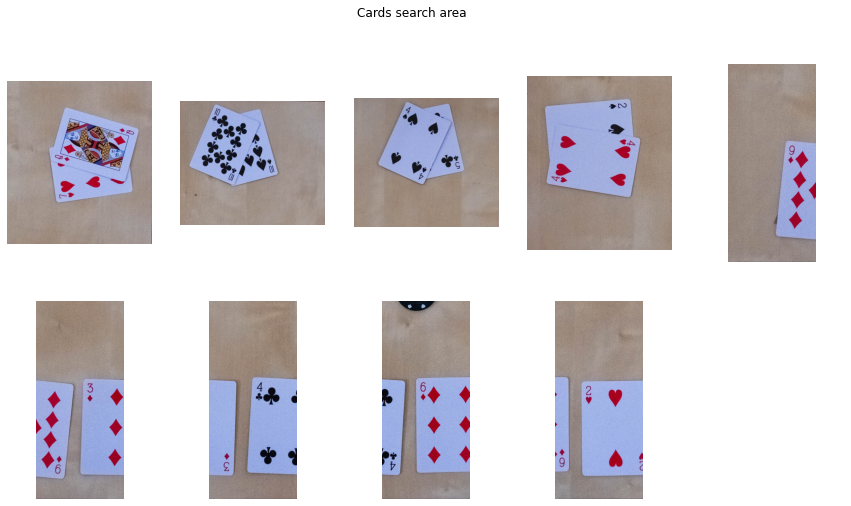

In [36]:
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize=(15,8))
for area, ax in zip(player_areas + common_areas, axes.flatten()):
    ax.imshow(area)
    ax.axis('off')
axes[-1,-1].axis('off')
fig.suptitle('Cards search area')
plt.show()

treat areas independently (work to be done to differentiate pairs of cards)

### (Simple sobel on equalized image) (unused)

In [17]:
sobel = edge_detector(equalized)

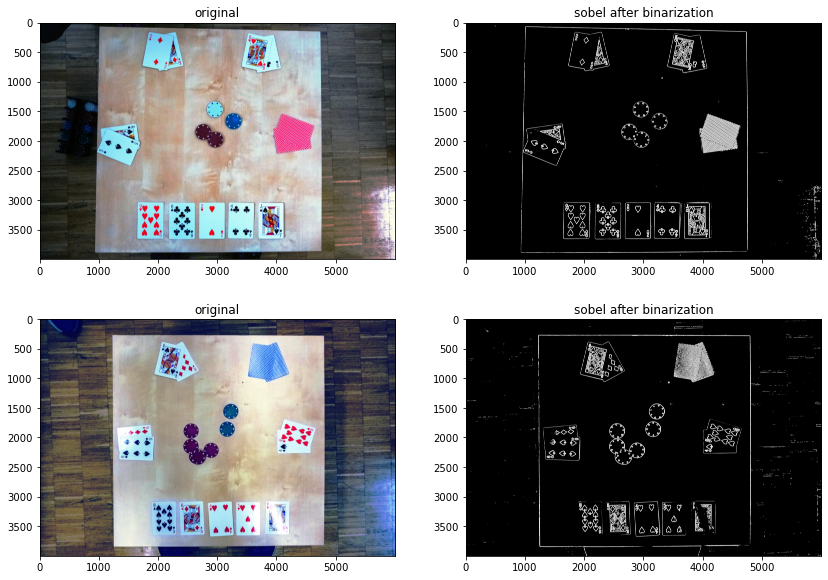

In [18]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(14,10))
for ax, image, edge in zip(axes, equalized, sobel):
    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('original')
    ax[1].imshow(edge, cmap=plt.cm.gray)
    ax[1].set_title('sobel after binarization')
plt.show()

## OTHER TRIALS

In [19]:
#crops = remove_background(images)

# plt.figure(figsize=(10,6))
# plt.imshow(crops[0])
# plt.axis('off')
# plt.title('Cropped image')
# plt.show()

# plt.figure(figsize=(10,6))
# plt.imshow(crops[1])
# plt.axis('off')
# plt.title('Cropped image')
# plt.show()

# fig, axes = plt.subplots(ncols = 7, nrows = 4, figsize=(20,20))
# for ax, image in zip(axes.flatten(), crops):
#     ax.imshow(image, cmap=plt.cm.gray)
# plt.show()

Current trial: use saturation and hue to create cards contours, which will define where we should look for letters, symbols,...

In [20]:
# img_regions = []
# for image in images:
# #     grayscale = skimage.color.rgb2gray(image)
# #     smoothed = filters.gaussian(grayscale, sigma = 3)
    
# #     gaus_1 = filters.gaussian(smoothed, sigma = 5)
# #     gaus_2 = filters.gaussian(smoothed, sigma = 7)
# #     dog = gaus_2 - gaus_1
    
# #     otsu = filters.threshold_otsu(dog)
# #     output = dog > otsu/2
# #     edges.append(regions)
    
    
# #     labeled_img = skimage.measure.label(image)
# #     labeled.append(labeled_img)
    
    
#     # grayscale = skimage.color.rgb2gray(image)
#     # grayscale = filters.median(grayscale)
#     # fill_img = flood_fill(grayscale, (50, 50), 0, tolerance = 0.1)
#     # filled.append(fill_img)
    
#     #grayscale = skimage.color.rgb2gray(image)
#     #channel = filters.gaussian(channel, sigma = 1)
#     #thresholds = filters.threshold_multiotsu(image=image_hue, classes = 2)
#     #regions_1 = np.digitize(image_hue, bins=thresholds)
    
#     #channel = filters.gaussian(channel, sigma = 1)
#     #thresholds = filters.threshold_multiotsu(image=image_blue, classes = 2)
#     #regions_2 = np.digitize(image_blue, bins=thresholds)
    
#     # Using the threshold values, we generate the regions.
#     #img_regions.append(regions_1 + (255-regions_2))
    
# fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(14,10))
# for ax, image, reg in zip(axes, images, img_regions):
#     ax[0].imshow(image, cmap=plt.cm.gray)
#     ax[0].set_title('original')
#     ax[1].imshow(reg, cmap=plt.cm.gray)
#     ax[1].set_title('combination of hue and saturation filtering')
# plt.show()

In [21]:
# plt.figure(figsize=(15,10))
# plt.imshow(img_regions[0], cmap=plt.cm.gray)
# plt.axis('off')
# plt.title('combination of hue and saturation filtering')
# plt.show()

# plt.figure(figsize=(15,10))
# plt.imshow(img_regions[1], cmap=plt.cm.gray)
# plt.axis('off')
# plt.title('combination of hue and saturation filtering')
# plt.show()

Sobel trials on Hue

In [22]:
#from skimage.morphology import closing, opening, disk, square

In [23]:
# fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(14,10))
# for i, (ax, hue) in enumerate(zip(axes, images_hsv)):
#     ax[0].imshow(images_hsv[i][:,:,0], cmap = plt.cm.gray)
#     ax[0].set_title('grayscale')
    
#     # sobel
#     sob = filters.sobel(images_hsv[i][:,:,0])
#     otsu = filters.threshold_otsu(sob)
#     output = sob < otsu
#     output = sob
    
#     ax[1].imshow(output, cmap=plt.cm.gray)
#     ax[1].set_title('sobel after binarization')

# plt.show()